In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [40]:
import os

df = pd.read_excel('../data/Online Retail.xlsx')
df.head()
df.tail()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [4]:
# Convert 'InvoiceDate' to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
import numpy as np

# Replace blank strings with NaN
df.replace("", np.nan, inplace=True)

# Drop rows with NaN values (including blank)
df_cleaned = df.dropna()

# Optionally, remove specific columns with NaN or blank values
df_cleaned = df.dropna(subset=['InvoiceNo', 'Quantity'])

# View the cleaned DataFrame
print(df_cleaned.head())


df['InvoiceDate'].head()

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]

In [13]:
# Convert 'InvoiceNo' to string, ensuring that any missing values are handled
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

df_non_canceled = df[~df['InvoiceNo'].str.startswith('C', na=False)]  # Non-canceled transactions
df_canceled = df[df['InvoiceNo'].str.startswith('C', na=False)]


In [14]:
df_non_canceled['TotalSales'] = df_non_canceled['Quantity'] * df_non_canceled['UnitPrice']
df_non_canceled['TotalSales'].head()

C:\Users\ratan\AppData\Local\Temp\ipykernel_15756\802365958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_canceled['TotalSales'] = df_non_canceled['Quantity'] * df_non_canceled['UnitPrice']


0    15.30
1    20.34
2    22.00
3    20.34
4    20.34
Name: TotalSales, dtype: float64

In [15]:
df_non_canceled_daily = df_non_canceled.groupby(df_non_canceled['InvoiceDate'].dt.date)['TotalSales'].sum().reset_index()
df_non_canceled_daily['InvoiceDate'] = pd.to_datetime(df_non_canceled_daily['InvoiceDate'])
df_non_canceled_daily.head()

,InvoiceDate,TotalSales
0,2010-12-01,58960.79
1,2010-12-02,47748.38
2,2010-12-03,46943.71
3,2010-12-05,31774.95
4,2010-12-06,54830.46


In [16]:
# Convert to a DataFrame and reset the index
df_canceled_daily = df_canceled.groupby(df_canceled['InvoiceDate'].dt.date)['TotalSales'].sum().reset_index()
df_canceled_daily['InvoiceDate'] = pd.to_datetime(df_canceled_daily['InvoiceDate'])


df_canceled_daily.head()


,InvoiceDate,TotalSales
0,2010-12-01,-325.23
1,2010-12-02,-1541.10
2,2010-12-03,-1323.25
3,2010-12-05,-391.00
4,2010-12-06,-970.28


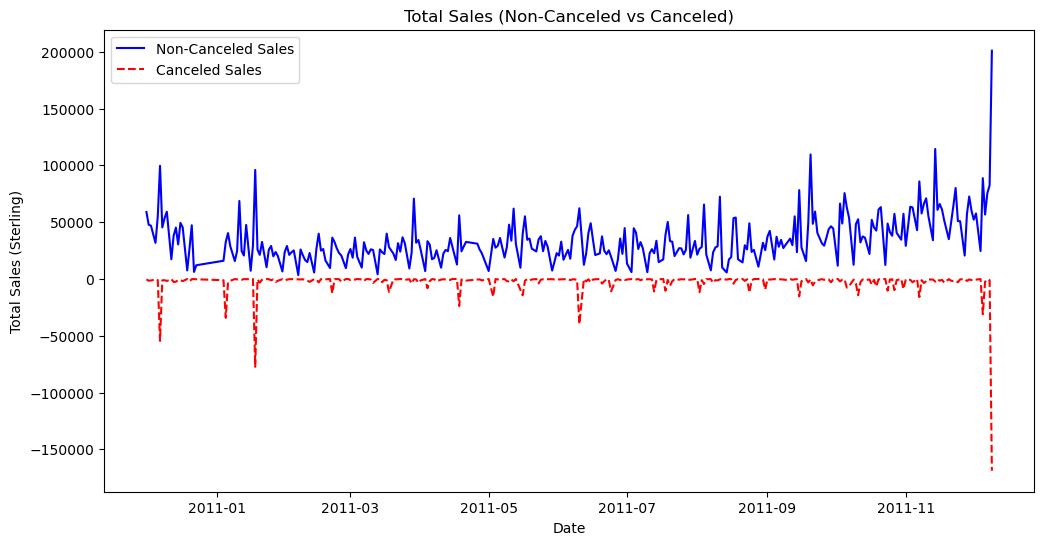

In [17]:
import matplotlib.pyplot as plt

df_non_canceled = df[~df['InvoiceNo'].str.startswith('C', na=False)]  # Non-canceled transactions
df_canceled = df[df['InvoiceNo'].str.startswith('C', na=False)]
# Grouping non-canceled transactions by date
df_non_canceled_daily = df_non_canceled.groupby(df_non_canceled['InvoiceDate'].dt.date)['TotalSales'].sum().reset_index()
df_non_canceled_daily['InvoiceDate'] = pd.to_datetime(df_non_canceled_daily['InvoiceDate'])

# Grouping canceled transactions by date
df_canceled_daily = df_canceled.groupby(df_canceled['InvoiceDate'].dt.date)['TotalSales'].sum().reset_index()
df_canceled_daily['InvoiceDate'] = pd.to_datetime(df_canceled_daily['InvoiceDate'])

# Plotting both non-canceled and canceled transactions
plt.figure(figsize=(12, 6))

# Plot non-canceled transactions
plt.plot(df_non_canceled_daily['InvoiceDate'], df_non_canceled_daily['TotalSales'], label='Non-Canceled Sales', color='blue')

# Plot canceled transactions
plt.plot(df_canceled_daily['InvoiceDate'], df_canceled_daily['TotalSales'], label='Canceled Sales', color='red', linestyle='--')

# Adding labels and title
plt.title('Total Sales (Non-Canceled vs Canceled)')
plt.xlabel('Date')
plt.ylabel('Total Sales (Sterling)')
plt.legend()

# Display the plot
plt.show()

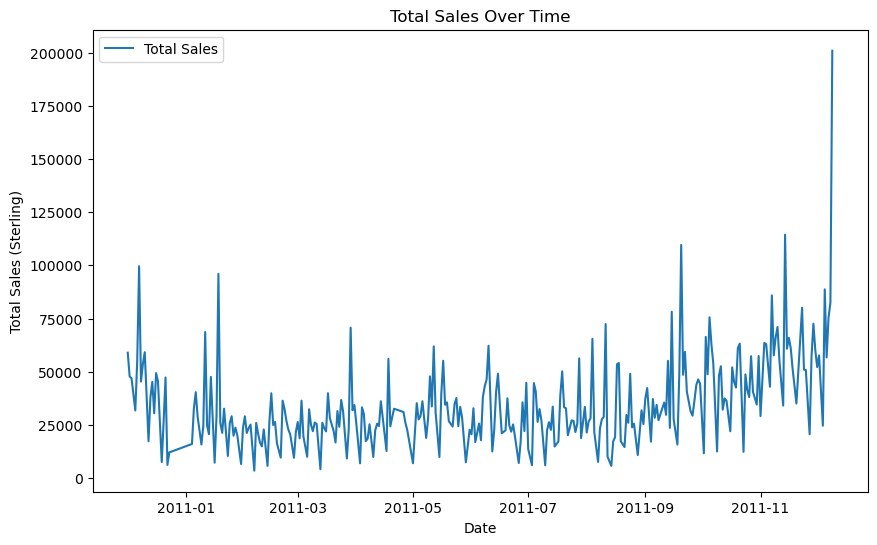

In [18]:
import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(10,6))
plt.plot(df_non_canceled_daily['InvoiceDate'], df_non_canceled_daily['TotalSales'], label='Total Sales')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales (Sterling)')
plt.legend()
plt.show()


In [28]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test
result = adfuller(df_non_canceled_daily['TotalSales'])

# Print the result
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: 0.04044090242427369
p-value: 0.9617514502891437


In [29]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test
result = adfuller(df_canceled_daily['TotalSales'])

# Print the result
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -4.115193603353491
p-value: 0.0009140085577905498


In [31]:
# Split data into training and test sets (e.g., last 12 months as test set)
non_canceled_train = df_non_canceled_daily.iloc[:-12]
non_canceled_test = df_non_canceled_daily.iloc[-12:]


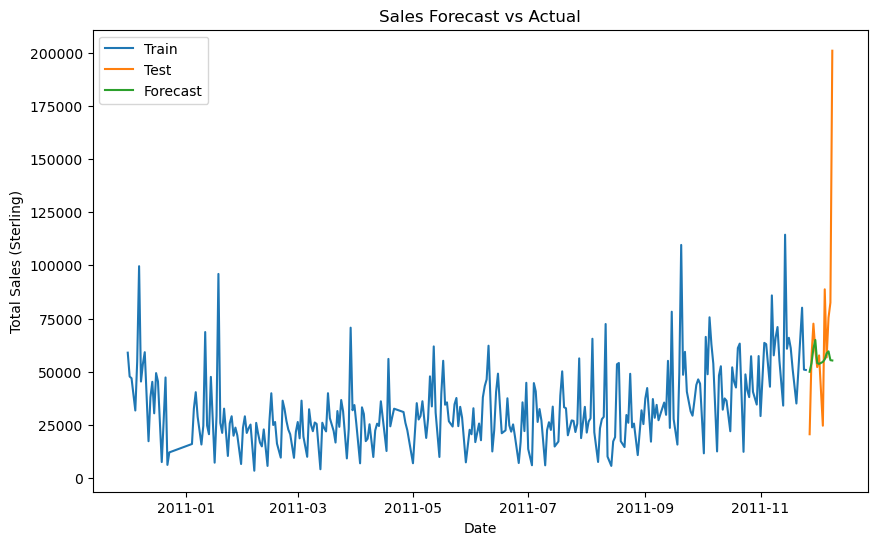

In [32]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model (adjust p, d, q as needed)
model = ARIMA(non_canceled_train['TotalSales'], order=(5,1,0))  # Example: p=5, d=1, q=0
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(non_canceled_test))

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(non_canceled_train['InvoiceDate'], non_canceled_train['TotalSales'], label='Train')
plt.plot(non_canceled_test['InvoiceDate'], non_canceled_test['TotalSales'], label='Test')
plt.plot(non_canceled_test['InvoiceDate'], forecast, label='Forecast')
plt.title('Sales Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Total Sales (Sterling)')
plt.legend()
plt.show()


In [33]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(non_canceled_test['TotalSales'], forecast))
print('RMSE:', rmse)


RMSE: 45854.811971120595


In [34]:
# Forecast future sales (e.g., next 6 months)
future_forecast = model_fit.forecast(steps=6)

print('Future Forecast:', future_forecast)


Future Forecast: 293    49985.648586
294    54078.457139
295    60872.440482
296    64931.778946
297    54086.886174
298    53671.871650
Name: predicted_mean, dtype: float64


In [35]:
# Check if there are canceled transactions
print(f"Number of canceled transactions: {len(df_canceled)}")


Number of canceled transactions: 9288


In [36]:
# Split data into training and test sets (e.g., last 12 months as test set)
canceled_train = df_canceled_daily.iloc[:-12]
canceled_test = df_canceled_daily.iloc[-12:]


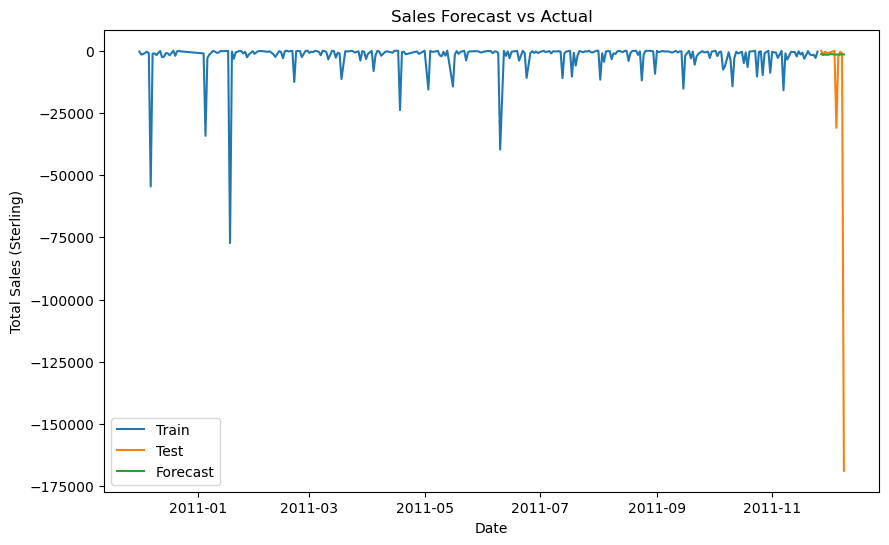

In [37]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model (adjust p, d, q as needed)
model = ARIMA(canceled_train['TotalSales'], order=(5,1,0))  # Example: p=5, d=1, q=0
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(canceled_test))

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(canceled_train['InvoiceDate'], canceled_train['TotalSales'], label='Train')
plt.plot(canceled_test['InvoiceDate'], canceled_test['TotalSales'], label='Test')
plt.plot(canceled_test['InvoiceDate'], forecast, label='Forecast')
plt.title('Sales Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Total Sales (Sterling)')
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(canceled_test['TotalSales'], forecast))
print('RMSE:', rmse)

RMSE: 49044.001417479834


In [39]:
# Forecast future sales (e.g., next 6 months)
future_forecast = model_fit.forecast(steps=6)

print('Future Forecast:', future_forecast)

Future Forecast: 290   -1399.432745
291   -1600.217007
292   -1609.208862
293   -1585.248535
294   -1595.425354
295   -1347.371526
Name: predicted_mean, dtype: float64
